In [1]:
%cd /home/Reguformer/notebooks

/home/Reguformer/notebooks


In [2]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.utils.data import DataLoader

from copy import deepcopy
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

from trans_oil_gas import utils_dataset, utils_emb, utils_fix_seeds, utils_model

Set parameters for plots.

In [3]:
plt.rc('font', size=16)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # legend fontsize
plt.rc('figure', titlesize=16)   # fontsize of the figure title

Choose GPU device if it is available.

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
gpu = [0] if 'cuda' in device.type else 0
device, gpu

(device(type='cpu'), 0)

Fix all possible seeds for results reproducibility.

In [5]:
utils_fix_seeds.fix_seeds(device=device)

# Read data

Reading of already preprocessed data (here synthetic dataset with the same columns as in the original one is presented).

In [6]:
df = pd.read_csv('../data/synthetic_well_log_data.csv')
df

,DRHO,DENS,GR,DTC,WELLNAME
0,0.01778,2.3794,1.214982,101.5516,26
1,0.01701,2.3705,1.086457,101.6722,26
2,0.01624,2.3615,0.957933,101.7928,26
3,0.01779,2.3593,0.493992,101.1051,26
4,0.02008,2.3591,-0.076734,100.1601,26
...,...,...,...,...,...
730,0.11269,2.6161,0.742381,92.0410,127
731,0.11269,2.6161,0.775581,92.1752,127
732,0.11269,2.6161,0.686798,91.6055,127
733,0.11269,2.6161,0.614402,91.7522,127


In [7]:
slice_len = 100
well_column = "WELLNAME"

In [8]:
path_to_save = './saves_emb_quality-tsne/'

if not os.path.exists(path_to_save):
    os.mkdir(path_to_save)

# Generate dataset and create dataloader

In [9]:
_, val_slice_dataset = utils_dataset.generate_datasets(
    df, df,
    well_column='WELLNAME',
    slice_len=slice_len,
    path_to_saves=path_to_save,
    results_len_train=0,
    # results_len_test=5000,
    results_len_test=50,
)    

# Models' params

In [10]:
shared_fixed_params = {
    "enc_in": 4,
    "distil": None,
    "device": device,
    "output_attention": False,
    "n_seq": 100
}
fixed_params_tr = {
    "attn": "full",
    "activation": "relu",
}
fixed_params_reguformer = {
    "attn": "prob",
    "activation": "gelu",
}
model_names = {
    'None-siamese': 'Siamese Transformer',
    'topQ-siamese': 'Siamese RegTr with top queries (Informer)',
    'randQ_randK-siamese': 'Siamese RegTr with random queries and keys',
    'None-triplet': 'Triplet Transformer',
    'topQ-triplet': 'Triplet RegTr with top queries (Informer)',
    'randQ_randK-triplet': 'Triplet RegTr with random queries and keys', 
}

In [11]:
path_to_models = "./saves_all_models/"

In [12]:
def plot_embeddings(
    embeddings_view,
    targets,
    ax=None,
):
    """Plot embeddings using t-SNE.
    :param embeddings: embeddings
    :param targets: classes
    :param ax: optional axes to plot on
    :param seed: random seed for reproducibility
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(16, 9))
    if targets is not None:
        colors = [
            'blue',
            'orange',
            'green',
            'red',
            'magenta',
            'indigo',
            'salmon',
            'cyan',
            'black',
            'gold', # 10
            'brown',
            'plum',
            'lightgreen',
            'pink',
            'purple',
            'grey',
            'peachpuff',
            'maroon',
            'khaki',
            'navy', # 20
            'lime',
            'tan',
            'olive',
            'yellow',
            'bisque',
            'limegreen',
            'forestgreen',
            'mediumblue',
            'teal',
            'yellow', # 30
            
        ]
        for y, c in zip(np.unique(targets), colors):
            ax.scatter(
                embeddings_view[targets == y, 0],
                embeddings_view[targets == y, 1],
                label=f"well {int(y)}",
                color=c,
                s=50,
            )
    else:
        ax.scatter(*embeddings_view.T)
        for i, (x, y) in enumerate(embeddings_view):
            ax.annotate(str(i), (x, y))
    return ax

4it [00:00, 27.28it/s]

Model type: None	 Loss type: siamese


21it [00:00, 24.67it/s]

50it [00:02, 24.39it/s]
2it [00:00, 19.82it/s]

Model type: topQ	 Loss type: siamese


50it [00:03, 15.76it/s]
0it [00:00, ?it/s]

Model type: randQ_randK	 Loss type: siamese


50it [00:05,  9.31it/s]
2it [00:00, 11.61it/s]

Model type: None	 Loss type: triplet


50it [00:02, 23.26it/s]
1it [00:00,  7.90it/s]

Model type: topQ	 Loss type: triplet


50it [00:08,  5.99it/s]
2it [00:00, 18.81it/s]

Model type: randQ_randK	 Loss type: triplet


50it [00:02, 17.08it/s]


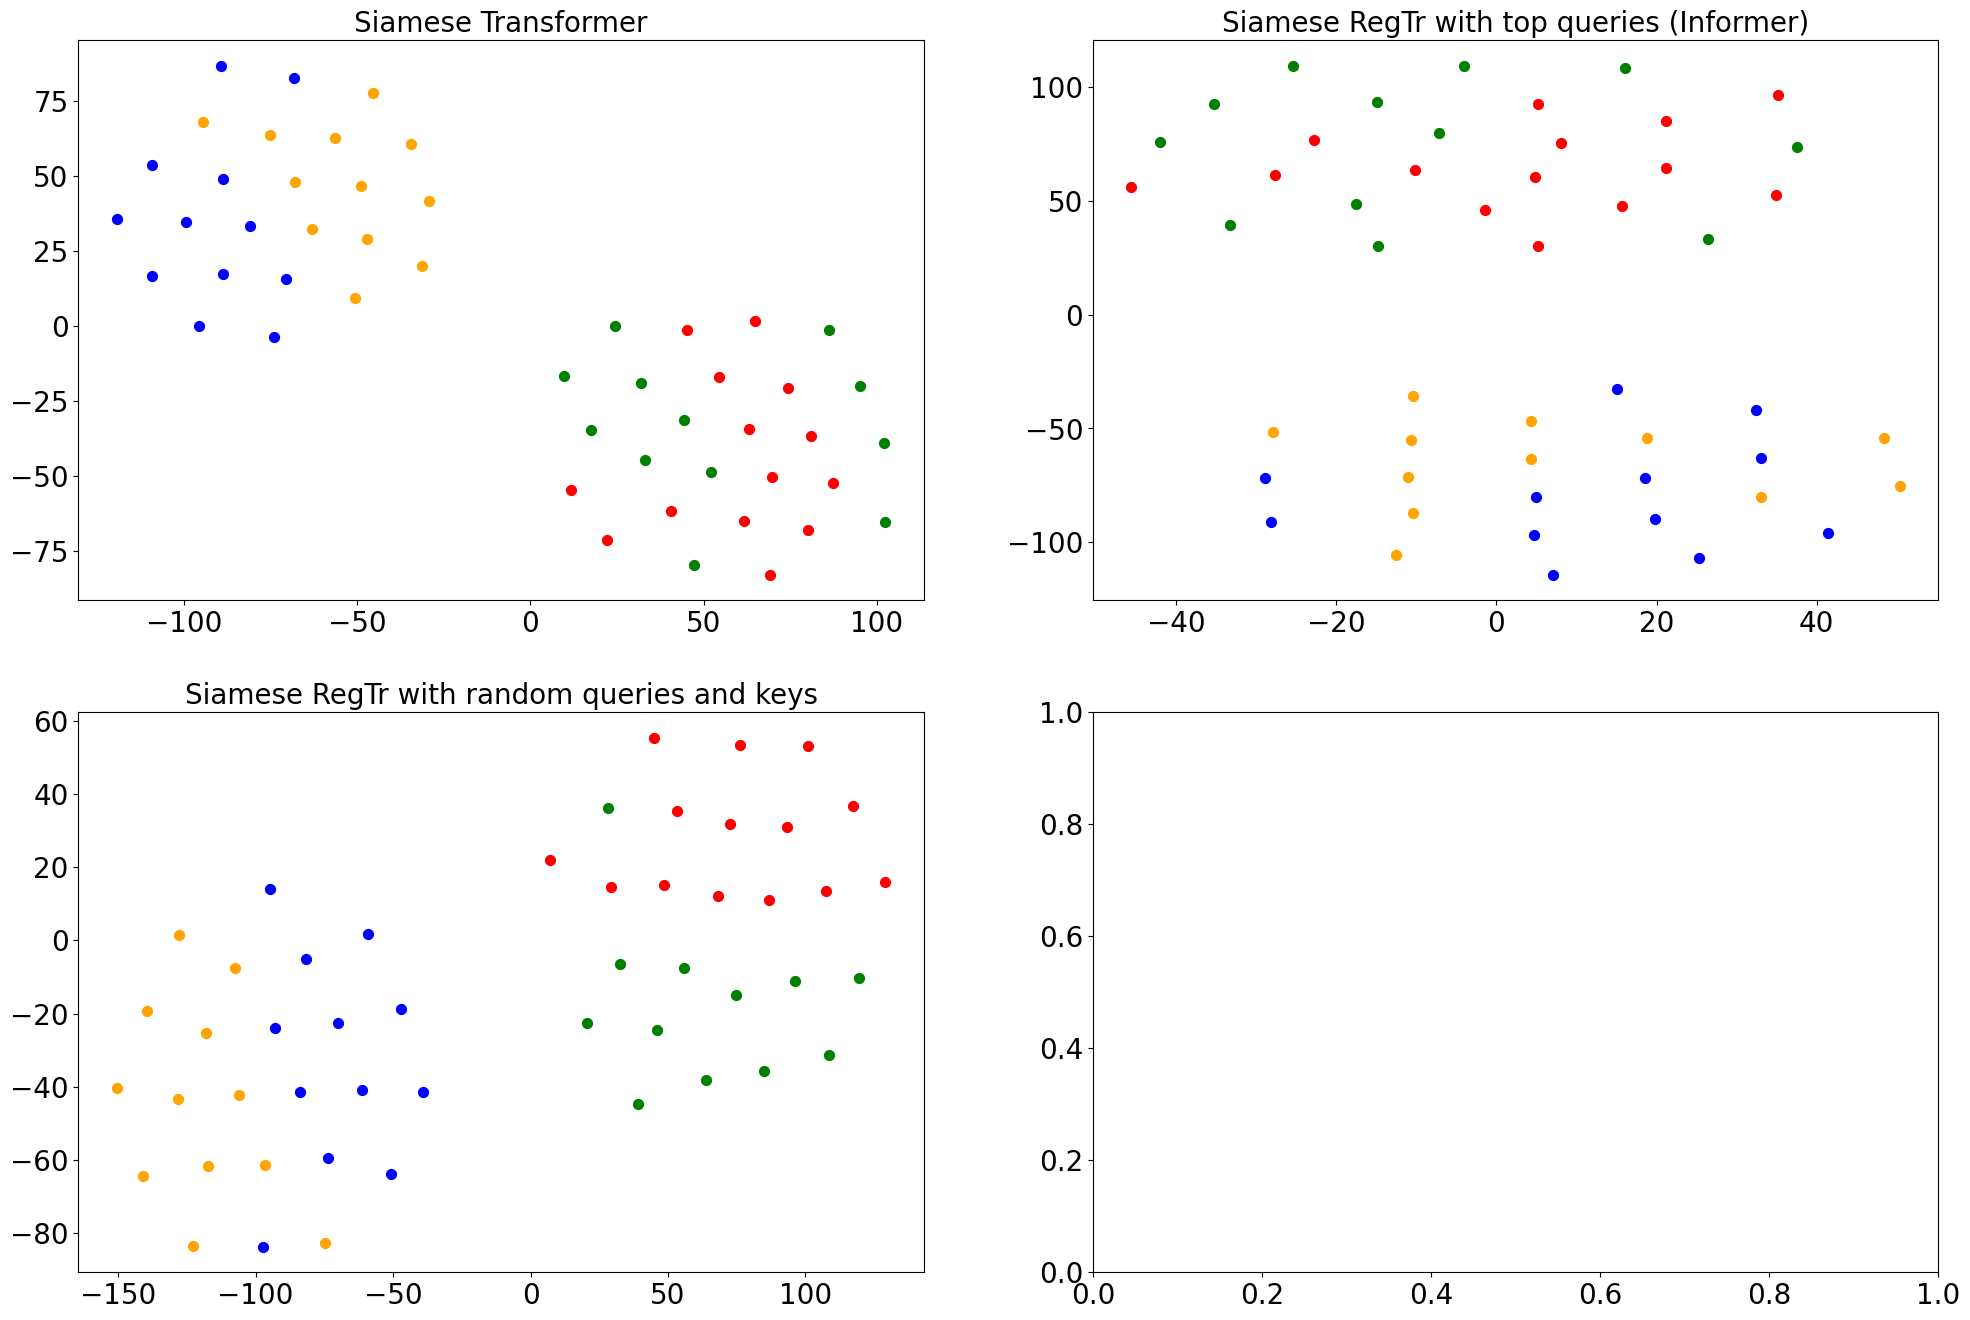

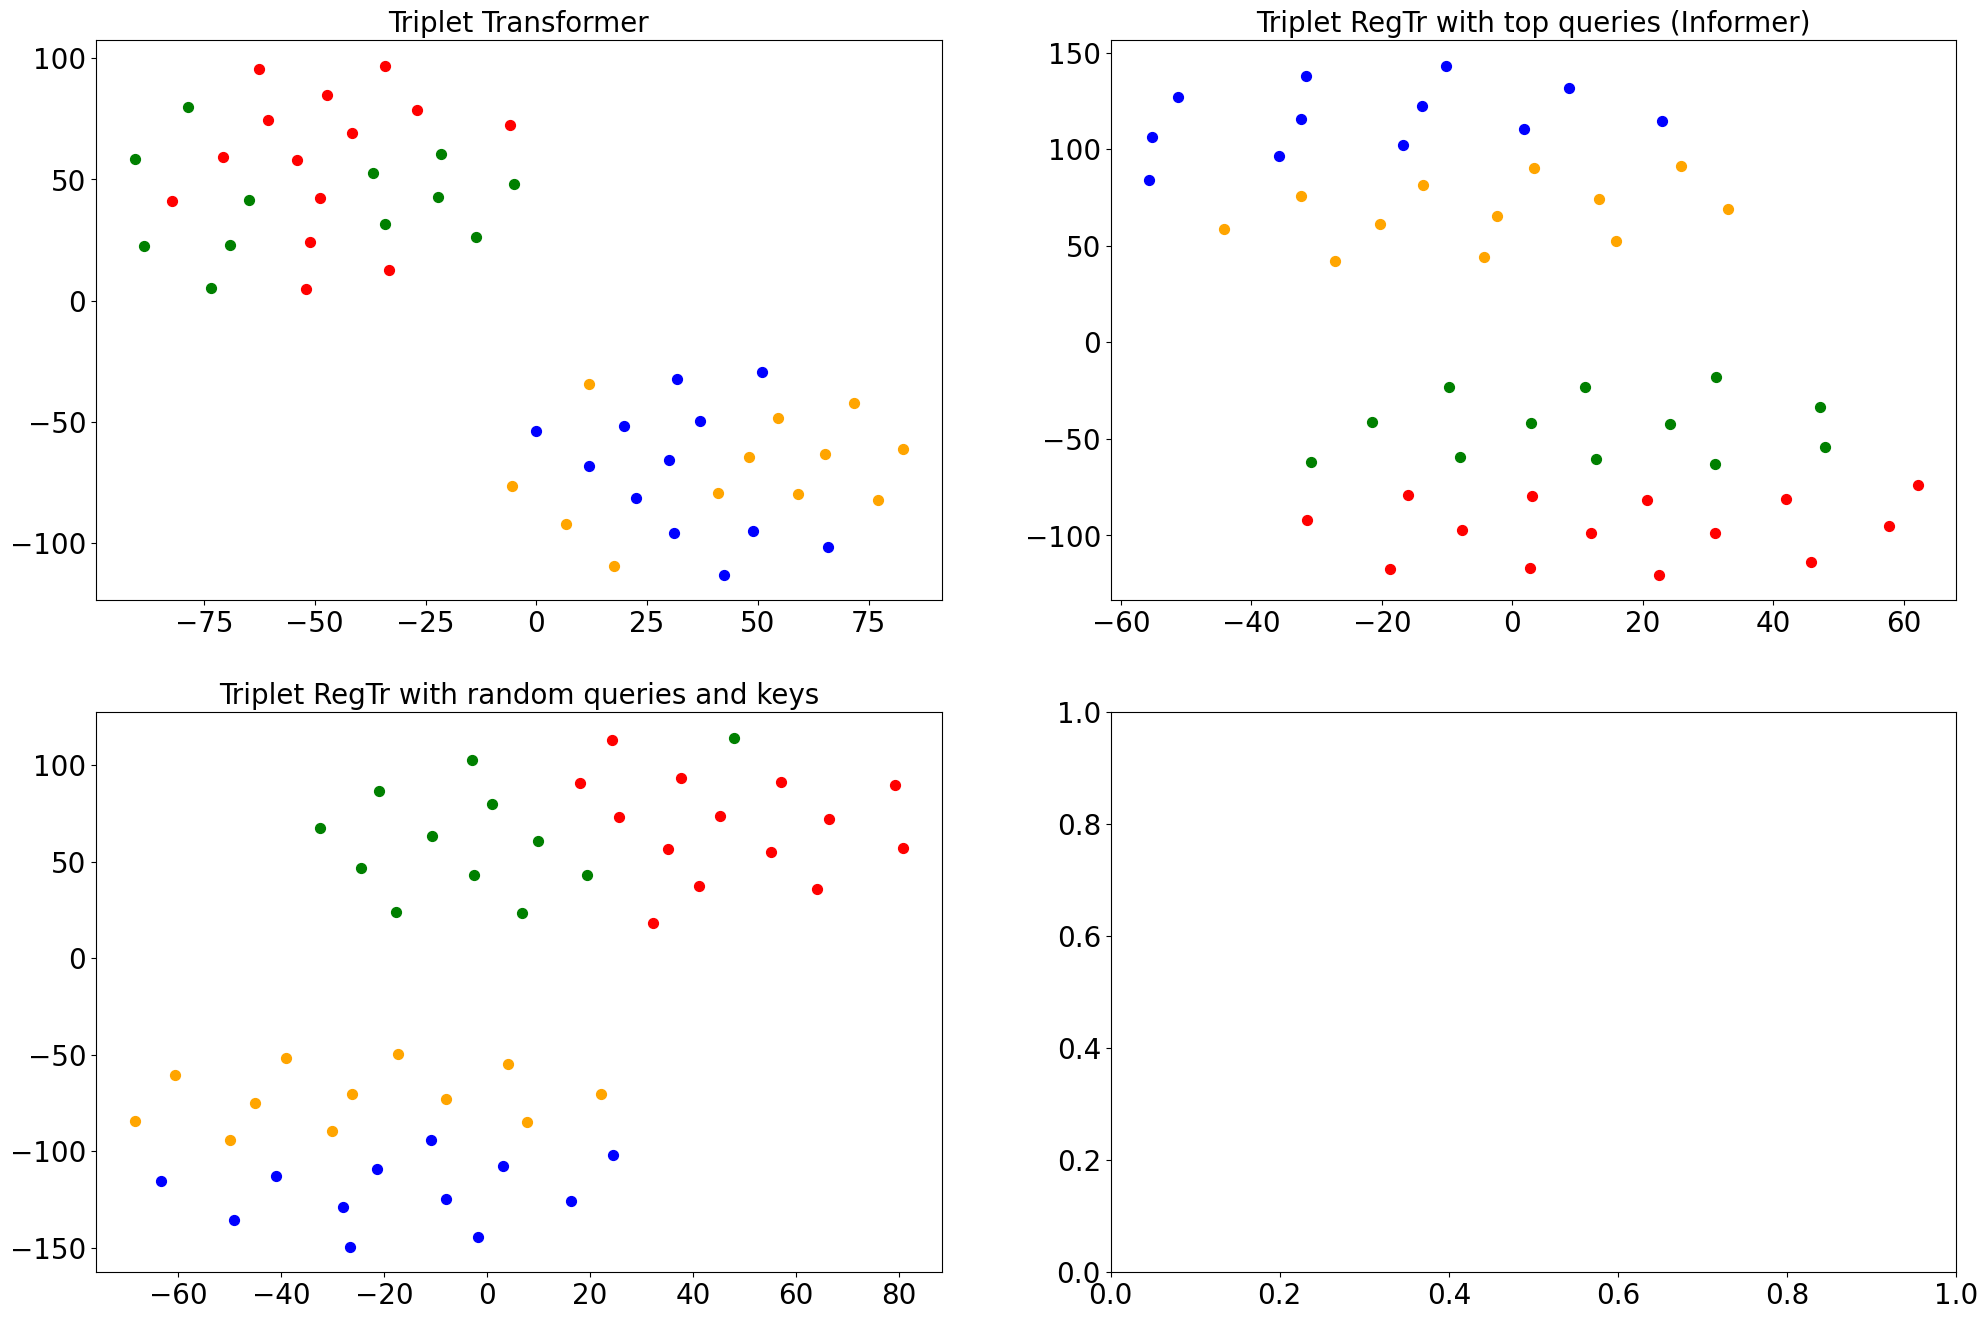

In [13]:
n_rows, n_cols = 2, 2 

for loss_type in ["siamese", "triplet"]:
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(24, 16))

    for i, model_type in enumerate(["None", "topQ", "randQ_randK"]):
        with open(os.path.join(path_to_models, "best_params_{}_reguformer_{}.json".format(loss_type, model_type)), "r") as f:
            best_params = json.load(f)

        if "None" in model_type:
            fixed_params = deepcopy(fixed_params_tr)
            enc_type = "transformer"
            reg_type = ""
        else:
            fixed_params = deepcopy(fixed_params_reguformer)
            enc_type = "reguformer"
            reg_type = "_" + model_type

        if "siamese" in loss_type:
            model = utils_model.SiameseArchitecture(
                encoder_type="reguformer", 
                fc_hidden_size=64, 
                **shared_fixed_params, 
                **fixed_params,
                **best_params,
            ).float()

        elif "triplet" in loss_type:
            model = utils_model.TripletArchitecture(
                encoder_type="reguformer", 
                **shared_fixed_params, 
                **fixed_params,
                **best_params,
            ).float()

        model.load_state_dict(torch.load(os.path.join(path_to_models, "res_{}_{}{}.pth".format(loss_type, enc_type, reg_type)), map_location=device))
        print("Model type: {}\t Loss type: {}".format(model_type, loss_type))

        model = utils_model.SiameseArchitecture(
            encoder_type="reguformer", 
            fc_hidden_size=64, 
            **shared_fixed_params,
            **fixed_params, 
            **best_params,
        ).float()

        model.eval()
        embeddings, wells = utils_emb.get_embeddings(
            model,
            model_type,
            val_slice_dataset,
            slice_len=slice_len,
            input_size=df.shape[1]-1
        )

        le = LabelEncoder()
        wells_tr = le.fit_transform(wells)
        embeddings_view = TSNE(random_state=123).fit_transform(embeddings.detach().cpu().numpy())

        ind1, ind2 = i // n_rows, i % n_cols
        ax[ind1, ind2] = plot_embeddings(
            embeddings_view, 
            wells_tr,
            ax=ax[ind1, ind2]
        )
        ax[ind1, ind2].set_title(model_names[model_type + "-" + loss_type])

    # Siamese LSTM 

    plt.savefig(os.path.join(path_to_save, "wells_{}.png".format(loss_type)), dpi=500, bbox_inches='tight')
    plt.savefig(os.path.join(path_to_save, "wells_{}.pdf".format(loss_type)), dpi=500, bbox_inches='tight')